In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

# --- Environment Setup ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_columns', 200)

# --- Data Loading ---
# Using a relative path as specified [cite: 40]
df = pd.read_csv("analytic_data2025_v2.csv", skiprows=[1], low_memory=False)
df['County FIPS Code'] = pd.to_numeric(df['County FIPS Code'], errors='coerce')
df_counties = df[df['County FIPS Code'] > 0].reset_index(drop=True)
print(f"Loaded data for {len(df_counties)} counties.")

Loaded data for 3152 counties.


In [18]:
# --- Variable Selection ---
rawvalue_cols = [c for c in df_counties.columns if "raw value" in c.lower()]
target_col = "Premature Death raw value"

# Health outcomes to be excluded from features 
outcome_cols = [
    "Premature Death raw value", "Premature Age-Adjusted Mortality raw value", "Life Expectancy raw value", 
    "Poor or Fair Health raw value", "Child Mortality raw value", "Infant Mortality raw value",
    "Frequent Physical Distress raw value", "Diabetes Prevalence raw value",
    "Poor Physical Health Days raw value", "Poor Mental Health Days raw value",
    "Low Birth Weight raw value"
]
feature_cols = [c for c in rawvalue_cols if c not in outcome_cols]
print(f"Selected {len(feature_cols)} features and 1 target variable ('{target_col}').")

Selected 79 features and 1 target variable ('Premature Death raw value').


In [19]:
# --- EDA and Preprocessing ---
df_clean = df_counties[['Name', 'State Abbreviation'] + feature_cols + [target_col]].copy()
for col in feature_cols + [target_col]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop columns with high percentage of missing values
missing_col_threshold = 0.30
col_missing_pct = df_clean[feature_cols].isna().mean()
cols_to_drop = col_missing_pct[col_missing_pct > missing_col_threshold].index.tolist()
feature_cols = [c for c in feature_cols if c not in cols_to_drop]
df_clean = df_clean[['Name', 'State Abbreviation'] + feature_cols + [target_col]]

# Drop rows where the target is missing
df_clean.dropna(subset=[target_col], inplace=True)
print(f"Data shape after cleaning: {df_clean.shape}")

# Display summary statistics 
print("\nSummary Statistics for Key Features:")
display(df_clean[['Adult Smoking raw value', 'Children in Poverty raw value', 'Median Household Income raw value']].describe())

Data shape after cleaning: (3088, 77)

Summary Statistics for Key Features:


,Adult Smoking raw value,Children in Poverty raw value,Median Household Income raw value
count,3080.000000,3080.000000,3080.000000
mean,0.180075,0.190391,65482.933442
std,0.038811,0.080966,16527.329774
min,0.059000,0.031000,28579.000000
25%,0.156000,0.131000,54548.250000
50%,0.178000,0.179000,62842.500000
75%,0.204000,0.234000,73010.000000
max,0.383000,0.632000,173655.000000


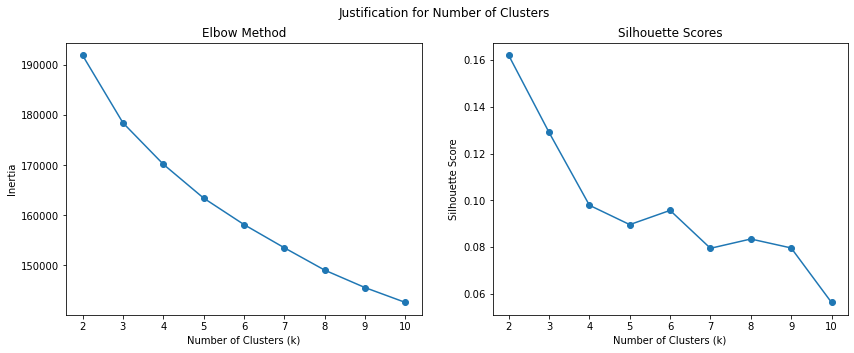

Assigned 3088 counties to 4 clusters.


In [20]:
# --- Clustering Analysis ---
X_cluster = df_clean[feature_cols].copy()
cluster_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_scaled = cluster_pipeline.fit_transform(X_cluster)

# Elbow method and Silhouette scores to justify k 
k_range = range(2, 11)
inertias = []
sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plotting justification for k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(k_range, inertias, marker='o')
ax1.set_title("Elbow Method")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax2.plot(k_range, sil_scores, marker='o')
ax2.set_title("Silhouette Scores")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
plt.suptitle("Justification for Number of Clusters")
plt.show()

# Fit final model with chosen k=4
BEST_K = 4
kmeans = KMeans(n_clusters=BEST_K, n_init=10, random_state=RANDOM_STATE)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)
print(f"Assigned {len(df_clean)} counties to {BEST_K} clusters.")

In [21]:
# --- Supervised Learning ---
X = df_clean[feature_cols]
y = df_clean[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model 1: Linear Regression 
lin_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_pred_lin, squared=False)
lin_r2 = r2_score(y_test, y_pred_lin)

# Model 2: Random Forest Regressor 
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

print("--- Model Evaluation  ---")
print(f"Linear Regression: RMSE={lin_rmse:.2f}, R^2={lin_r2:.3f}")
print(f"Random Forest:     RMSE={rf_rmse:.2f}, R^2={rf_r2:.3f}")

--- Model Evaluation  ---
Linear Regression: RMSE=1642.05, R^2=0.823
Random Forest:     RMSE=1752.19, R^2=0.799


In [22]:
# --- Feature Importance ---
importances = rf_pipe.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Five Most Important Factors Influencing Premature Death:")
display(feature_importance_df.head(5))

Five Most Important Factors Influencing Premature Death:


,feature,importance
20,Children in Poverty raw value,0.427478
21,Injury Deaths raw value,0.132320
63,% American Indian or Alaska Native raw value,0.119259
32,Teen Births raw value,0.038618
57,Motor Vehicle Crash Deaths raw value,0.019069
